In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from detection.rnn_detection import *
from simulations import lightcurve_simulation as lcsim
import visualize as vis

from scipy.ndimage import gaussian_filter1d

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [2]:
# import sys
# del sys.modules["detection.rnn_detection"]

In [3]:
rnn = torch.load("models/bigru1_sim.pt")

In [9]:
np.random.seed(42)
lc = lcsim.get_lightcurve(num_planets=2, min_transits=3, period_range=(2,100), t_max=27.4, 
                          max_attempts=4, max_snr_attempts=10, snr_range=(3,80), 
                          rdepth_range=(.5,5.), dur_range=(0,utils.hour2day(14)))
time, flux, pl_masks, params = lc
pl1, pl2 = pl_masks[0], pl_masks[1]
nontr = ~np.any(pl_masks, 0)

flux_ = (flux-1) / params["sigma"] 
flux_ = (flux_ - (-0.02693141794739591)) / 2.109453867034959
pts = get_pts(rnn, flux_.reshape(1,-1)).squeeze()

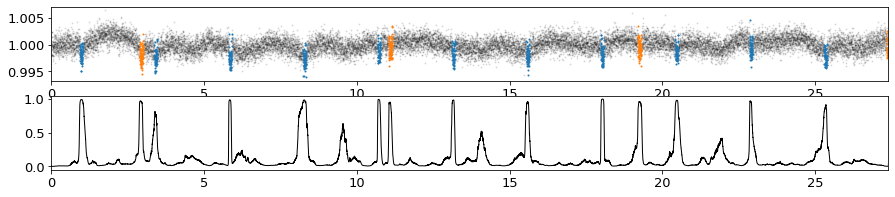

In [11]:
plt.figure(figsize=(15,3))
plt.subplot(2,1,1)
vis.plot(time[nontr], flux[nontr], c="black", a=0.1)
for msk in pl_masks:
    vis.plot(time[msk], flux[msk], c=plt.plot([])[0].get_color(), a=1)
plt.xlim(0,time[-1])

plt.subplot(2,1,2)
vis.plot(time, pts, scatter=0)
plt.xlim(0,time[-1])
plt.show()

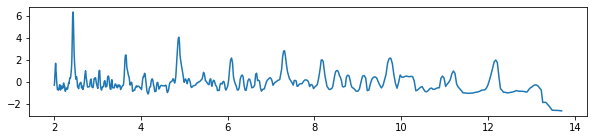

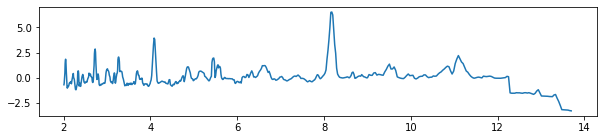

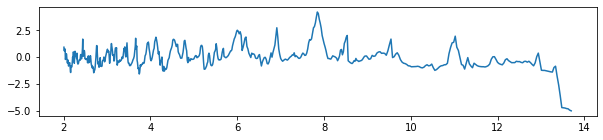

{6.390252771984485: {'period': 2.438888888888889,
  't0': 0.9569444444444445,
  'duration': 0.19444444444444375},
 6.53348664983046: {'period': 8.177777777777779,
  't0': 2.9069444444444446,
  'duration': 0.13333333333333464},
 4.229124881353901: {'period': 7.844444444444445,
  't0': 6.2347222222222225,
  'duration': 0.22222222222222232}}

In [12]:
algorithm1(pts, show_steps=True, smooth=True)

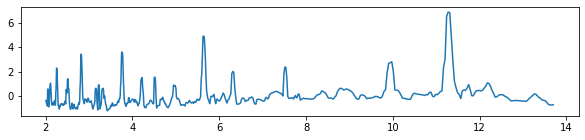

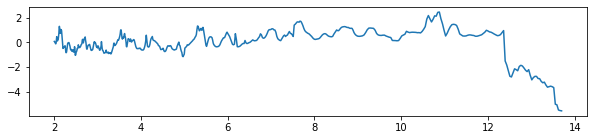

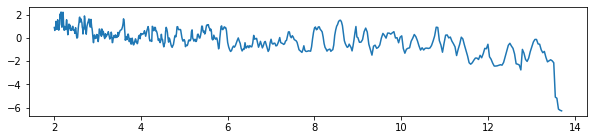

{6.872821037224188: {'period': 11.275,
  't0': 2.4347222222222222,
  'duration': 0.18055555555555713},
 2.474926888447116: {'period': 10.877777777777778,
  't0': 4.163888888888889,
  'duration': 0.39722222222222214},
 2.2200745071130474: {'period': 2.161111111111111,
  't0': 0.5361111111111111,
  'duration': 0.40000000000000124}}

In [329]:
[params["planets"][i]["pl_period"] for i in params["planets"]]

[11.280611948806344, 2.123390536030117]

0.5868359999999768 (0.1956143333333292)


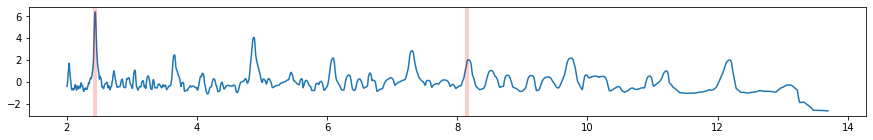

In [274]:


start = clock()

periods, scores, t0s, ntrs = get_spectra(time, tps_in.reshape(1,-1), 
                                              min_transits=3, p_min=2, p_max=None, step_mult=1)
print(clock()-start, f"({(clock()-start)/3})")

score = scores[0]
score = (score-np.mean(score)) / np.std(score)
plt.figure(figsize=(15,2))
plt.plot(periods, score)
for p in [params["planets"][i]["pl_period"] for i in params["planets"]]:
    if p < np.max(periods):
        plt.axvline(p, color="red", alpha=0.2, linewidth=4)